In [1]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split

In [2]:
# CSV 파일이 저장된 디렉토리 경로
directory = '../data/data'

# 디렉토리 내의 모든 파일 리스트를 가져옵니다
file_list = os.listdir(directory)

# "data_"가 포함된 CSV 파일들의 경로를 저장할 리스트
csv_files = []

# 파일 리스트를 순회하면서 "data_"가 포함된 CSV 파일을 찾습니다
for file in file_list:
    if file.endswith(".csv") and "data_" in file:
        csv_files.append(os.path.join(directory, file))

# CSV 파일들을 읽어서 DataFrame으로 저장합니다
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# 결과 확인
df.head()

,No,Heartbeat,Temperature,Spo2,UserCode,GyroX,GyroY,GyroZ,Time,Label
0,1,108.0,36.6,95.0,33.0,-0.040861,4.985047,6.510526,4.960000e+13,Downstairs
1,2,109.0,36.7,99.0,33.0,-0.463092,4.372132,7.436710,4.960000e+13,Downstairs
2,3,111.0,36.6,98.0,33.0,-0.299648,4.603678,6.510526,4.960000e+13,Downstairs
3,4,108.0,36.6,97.0,33.0,-0.272407,4.481094,6.360703,4.960000e+13,Downstairs
4,5,110.0,36.6,98.0,33.0,-1.525479,5.175732,7.164303,4.960000e+13,Downstairs


In [3]:
# 결측치 확인
df.isnull().sum()

No             0
Heartbeat      1
Temperature    1
Spo2           1
UserCode       1
GyroX          1
GyroY          1
GyroZ          2
Time           1
Label          1
dtype: int64

In [4]:
# 결측치가 삭제된 DataFrame 생성
df_cleaned = df.dropna()

# 결과 확인
print(df_cleaned)

             No  Heartbeat  Temperature  Spo2  UserCode     GyroX      GyroY   
0             1      108.0         36.6  95.0      33.0 -0.040861   4.985047  \
1             2      109.0         36.7  99.0      33.0 -0.463092   4.372132   
2             3      111.0         36.6  98.0      33.0 -0.299648   4.603678   
3             4      108.0         36.6  97.0      33.0 -0.272407   4.481094   
4             5      110.0         36.6  98.0      33.0 -1.525479   5.175732   
...         ...        ...          ...   ...       ...       ...        ...   
1048570  406772      128.0         36.6  99.0       7.0  5.520000   6.440000   
1048571  406773      133.0         36.8  96.0       7.0  2.140000   8.470000   
1048572  406774      131.0         36.7  95.0       7.0  6.090000   4.860000   
1048573  406775      142.0         36.8  96.0       7.0  5.010000   9.700000   
1048574  406776      136.0         36.6  96.0       7.0  4.140000  11.030000   

            GyroZ          Time       L

In [5]:
# 특성과 타겟 데이터로 분할
X = df_cleaned[['Temperature','Heartbeat','GyroX','GyroY','GyroZ']]
y = df_cleaned['Label']

# 테스트 세트와 트레인 세트로 분할 (70% 트레인, 30% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

# 결과 확인
print("X_train:")
print(X_train)
print("y_train:")
print(y_train)
print("X_test:")
print(X_test)
print("y_test:")
print(y_test)

X_train:
         Temperature  Heartbeat  GyroX  GyroY     GyroZ
593383          36.7      128.0  -2.60  13.53 -1.800000
1047394         36.6      133.0   2.87   8.24 -0.950000
357596          36.8      130.0   7.44  16.13 -5.240000
675228          36.6      136.0   9.58   8.54 -2.369940
428146          36.6      134.0  -4.33  -2.22  8.349273
...              ...        ...    ...    ...       ...
759363          36.7      130.0   2.18  15.05 -2.533385
535030          36.8      135.0   5.01  11.26  2.982856
573977          36.7      132.0  -1.84   5.63  4.399372
189636          36.7      133.0  -8.43  15.40 -0.994285
585903          36.7      142.0   7.70   5.22 -1.460000

[734001 rows x 5 columns]
y_train:
593383     Upstairs
1047394     Walking
357596      Jogging
675228      Walking
428146      Sitting
             ...   
759363      Walking
535030     Upstairs
573977     Upstairs
189636      Jogging
585903     Upstairs
Name: Label, Length: 734001, dtype: object
X_test:
         Tem

In [6]:
# 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
def perform_tsne(X_data, y_data, perplexities, n_iter=1000, img_name_prefix='t-sne'):
    for index, perplexity in enumerate(perplexities):
        X_reduced = TSNE(verbose=2, perplexity=perplexity).fit_transform(X_data)
        print('t-SNE을 활용한 시각화')
        df = pd.DataFrame({'x': X_reduced[:, 0], 'y': X_reduced[:, 1], 'label': y_data})
        sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, palette="Set1",
                   markers=['^', 'v', 's', 'o', '1', '2'])
        plt.title(f"perplexity : {perplexity} and max_iter : {n_iter}")
        img_name = img_name_prefix + f'_perp_{perplexity}_iter_{n_iter}.png'
        plt.savefig(img_name)
        plt.show()
        print('Done')

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 734001 samples in 1.787s...
[t-SNE] Computed neighbors for 734001 samples in 91.354s...
[t-SNE] Computed conditional probabilities for sample 1000 / 734001
[t-SNE] Computed conditional probabilities for sample 2000 / 734001
[t-SNE] Computed conditional probabilities for sample 3000 / 734001
[t-SNE] Computed conditional probabilities for sample 4000 / 734001
[t-SNE] Computed conditional probabilities for sample 5000 / 734001
[t-SNE] Computed conditional probabilities for sample 6000 / 734001
[t-SNE] Computed conditional probabilities for sample 7000 / 734001
[t-SNE] Computed conditional probabilities for sample 8000 / 734001
[t-SNE] Computed conditional probabilities for sample 9000 / 734001
[t-SNE] Computed conditional probabilities for sample 10000 / 734001
[t-SNE] Computed conditional probabilities for sample 11000 / 734001
[t-SNE] Computed conditional probabilities for sample 12000 / 734001
[t-SNE] Computed conditional probab

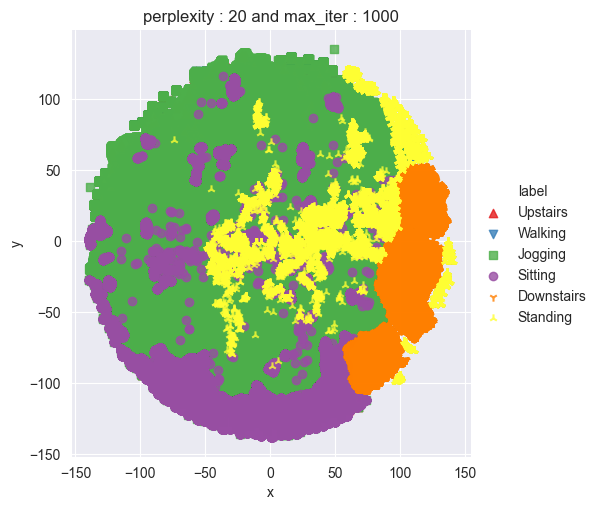

Done


In [8]:
X_pre_tsne = X_train
y_pre_tsne = y_train
perform_tsne(X_data=X_pre_tsne, y_data=y_pre_tsne, perplexities=[20])

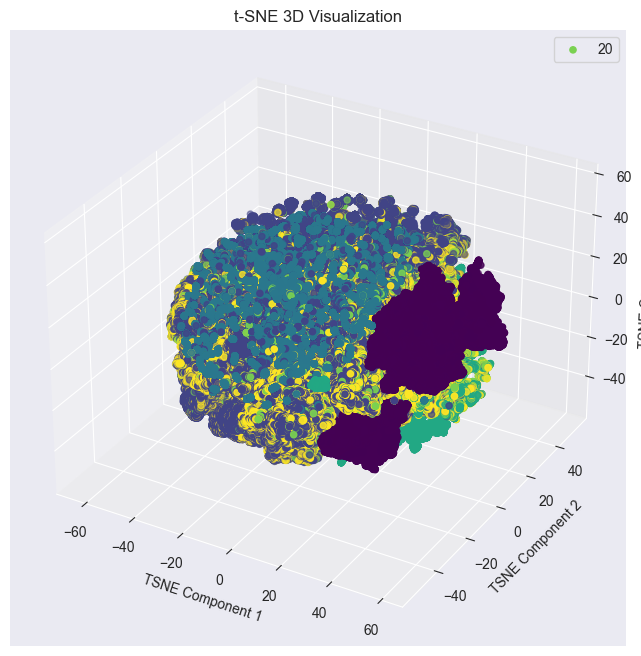

In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def perform_tsne_3d(X_data, y_data, perplexities):
    tsne = TSNE(n_components=3, random_state=42)
    X_tsne = tsne.fit_transform(X_data)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    y_colors = np.unique(y_data)
    y_numeric = np.arange(len(y_colors))
    y_data_numeric = np.zeros_like(y_data)
    for i, color in enumerate(y_colors):
        y_data_numeric[y_data == color] = y_numeric[i]

    for perplexity in perplexities:
        ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y_data_numeric, cmap='viridis', label=perplexity)

    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    ax.set_title('t-SNE 3D Visualization')
    ax.legend()

    plt.show()

# 3차원 t-SNE 시각화 실행
X_pre_tsne = X_train
y_pre_tsne = y_train
perform_tsne_3d(X_data=X_pre_tsne, y_data=y_pre_tsne, perplexities=[20])
